<a href="https://colab.research.google.com/github/lindswang/cis545finalproject/blob/main/EDA_vFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load in packages and data

In [1]:
!pip install chart_studio

     |████████████████████████████████| 64 kB 1.8 MB/s 


In [2]:
import datetime
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import pandas as pd
import scipy.stats as ss
import seaborn as sns
import statsmodels.api as sm
import plotly.graph_objects as go

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
sns.set(rc = {'figure.figsize':(15,8)})

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# Load-in data that was cleaned in previous notebook
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1qPjXWmEPl5lhSlgZ7u0Pfk0H2oOUxGCy',
                                    dest_path='/content/directory.csv')
gdd.download_file_from_google_drive(file_id='16el5-XYCIt1ouHCAL_jcJggO0P0ZTjKo',
                                    dest_path='/content/sat_act.csv')
gdd.download_file_from_google_drive(file_id='1EcIM4bXB3L7pm2Px-L10v9a2p-g4MsF2',
                                    dest_path='/content/math.csv')
gdd.download_file_from_google_drive(file_id='1NaqHoRbKXsAoGC07784IbnQyCDL4nafX',
                                    dest_path='/content/read.csv')
gdd.download_file_from_google_drive(file_id='1LE4Eul3rogD9bFCR0zoxWHG0s_MiP8Wv',
                                    dest_path='/content/tsne_output.csv')

directory_df = pd.read_csv('directory.csv', dtype=str)
sat_act_df = pd.read_csv('sat_act.csv', dtype=str)
math_df = pd.read_csv('math.csv', dtype=str)
read_df = pd.read_csv('read.csv', dtype=str)

In [4]:
# Drop some columns that were created when df was read into .csv
directory_df.drop(columns=['Unnamed: 0'], inplace=True)
sat_act_df.drop(columns=['Unnamed: 0'], inplace=True)
math_df.drop(columns=['Unnamed: 0'], inplace=True)
read_df.drop(columns=['Unnamed: 0'], inplace=True)

### Data Cleaning

In [5]:
# Casting to correct datatypes
directory_df.dtypes
directory_df.head()

int_cols = ['ncessch','fips','enrollment']

for c in directory_df.columns:
  if c in int_cols:
    directory_df[c] = directory_df[c].astype(int)

directory_df.drop(columns=['year','ncessch_num','school_id','phone'],inplace=True)

In [6]:
# Casting to correct datatypes
int_cols = ['ncessch','fips']

for c in sat_act_df.columns:
  if c in int_cols:
    sat_act_df[c] = sat_act_df[c].astype(int)
  elif c == 'crdc_id':
    pass
  else:
    sat_act_df[c] = sat_act_df[c].astype(float)

In [7]:
# Casting to correct datatypes
int_cols = ['ncessch','fips','math_test_num_valid']

for c in math_df.columns:
  if c in int_cols:
    math_df[c] = math_df[c].astype(int)
  elif c == 'school_name':
    pass
  else:
    math_df[c] = math_df[c].astype(float)

for c in read_df.columns:
  if c in int_cols:
    read_df[c] = read_df[c].astype(int)
  elif c == 'school_name':
    pass
  else:
    read_df[c] = read_df[c].astype(float)


## Merging Data

In [8]:
# Merging directory data with SAT/ACT data
directory_sat_act_df = directory_df.merge(sat_act_df, how='left', on='ncessch', indicator=True)
print((directory_sat_act_df._merge == 'both').sum()/directory_sat_act_df.shape[0])
# Note that we have SAT ACT data for >98% of schools!

directory_sat_act_df = directory_df.merge(sat_act_df, how='inner', on='ncessch')

0.9818459915611815


In [9]:
# Merging directory data with state assessment data
directory_read_df = directory_df.merge(read_df, how='left', on='ncessch', indicator=True)
print((directory_read_df._merge == 'both').sum()/directory_read_df.shape[0])
# We have state reading assessment data for ~87% of schools!

directory_math_df = directory_df.merge(math_df, how='left', on='ncessch', indicator=True)
print((directory_math_df._merge == 'both').sum()/directory_read_df.shape[0])
# We have state math assessment data for ~87% of schools!

0.8732805907172996
0.8731645569620253


In [10]:
# Merging all three data sources together 
alldata_df = directory_df.merge(sat_act_df, how='inner', on='ncessch').merge(math_df, how='inner', on='ncessch').merge(read_df, how='inner', on='ncessch',suffixes=('_math','_read'))

## EDA

### SAT/ACT Data

In [11]:
# Creating a column of percentage of people that took the SAT/ACT
directory_sat_act_df['pct_sat_act'] = directory_sat_act_df['sex_race_disability_lep_99_99_99_99'] / directory_sat_act_df.enrollment
alldata_df['pct_sat_act'] = alldata_df['sex_race_disability_lep_99_99_99_99'] / alldata_df.enrollment

In [12]:
# Converting np.inf to np.nan to make it easier to deal with
directory_sat_act_df['pct_sat_act'].replace([np.inf, -np.inf], np.nan, inplace=True)

In [13]:
# 29 schools reported more people taking the SAT than enrolled...
(directory_sat_act_df['pct_sat_act'] > 1).sum() 
directory_sat_act_df[(directory_sat_act_df['pct_sat_act'] > 1)][['school_name','enrollment','sex_race_disability_lep_99_99_99_99']].head()

# Drop those schools
clean_directory_sat_act_df = directory_sat_act_df[(directory_sat_act_df['pct_sat_act'] <= 1)]
alldata_df = alldata_df[(alldata_df['pct_sat_act'] <= 1)]

# Only look at high schools, since highschool is our area of interest when we look at SAT/ACT tests
clean_directory_sat_act_df = clean_directory_sat_act_df[clean_directory_sat_act_df.school_level == '3']

In [14]:
# Examine what's up with schools with no SAT/ACT test-takers

zero_sat_state = clean_directory_sat_act_df[(clean_directory_sat_act_df['pct_sat_act'] == 0.0)].state_location.value_counts()
# Mostly California schools

sat_state = clean_directory_sat_act_df.state_location.value_counts()
# Create a helpful series for further analysis

clean_directory_sat_act_df[(clean_directory_sat_act_df['pct_sat_act'] == 0.0)].school_type.value_counts()
# Mostly regular schools


1    1276
4    1206
2     185
3      64
Name: school_type, dtype: int64

In [15]:
# Continued from prev. cell: Examine what's up with schools with no SAT/ACT test-takers

zero_sat_state = pd.DataFrame(zero_sat_state).reset_index().rename(columns = {'state_location':'num highschools with no SAT/ACT'})
sat_state = pd.DataFrame(sat_state).reset_index().rename(columns = {'state_location':'num highschools'})
result = sat_state.merge(zero_sat_state, how = 'left', on = 'index')[['index','num highschools','num highschools with no SAT/ACT']]

In [16]:
# Continued from prev. cell: Examine what's up with schools with no SAT/ACT test-takers

result['num highschools with no SAT/ACT'].replace([np.inf, -np.inf,np.nan], 0, inplace=True)
result['pct no sat'] = result['num highschools with no SAT/ACT'] / result['num highschools']
result = result.sort_values(by = 'pct no sat', ascending = False)
result.head()

index  num highschools  num highschools with no SAT/ACT  pct no sat
34    PR              196                           196.00        1.00
11    WA              541                           193.00        0.36
0     CA             2097                           700.00        0.33
7     MN              681                           175.00        0.26
29    LA              255                            63.00        0.25

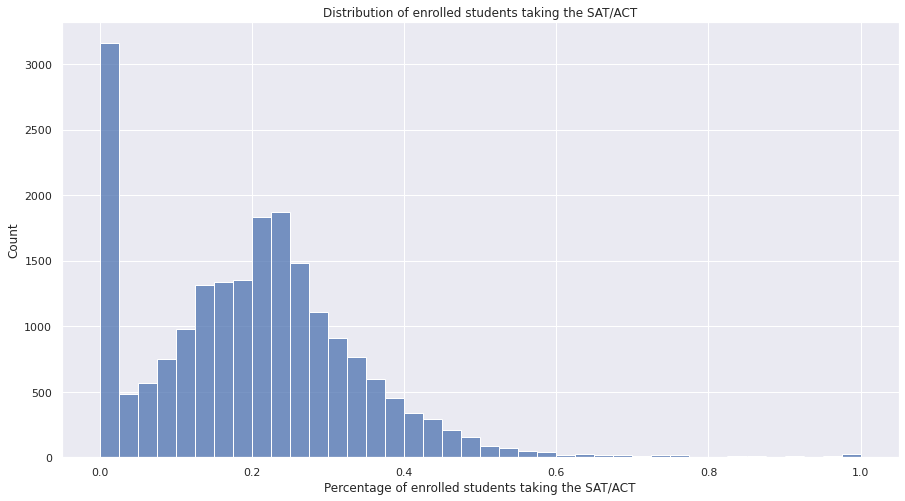

In [17]:
# Plot the distribution of Percentage of enrolled students taking the SAT/ACT
plot = sns.histplot(clean_directory_sat_act_df.pct_sat_act, binwidth = 0.025);
plot.set(xlabel = 'Percentage of enrolled students taking the SAT/ACT', title = 'Distribution of enrolled students taking the SAT/ACT');

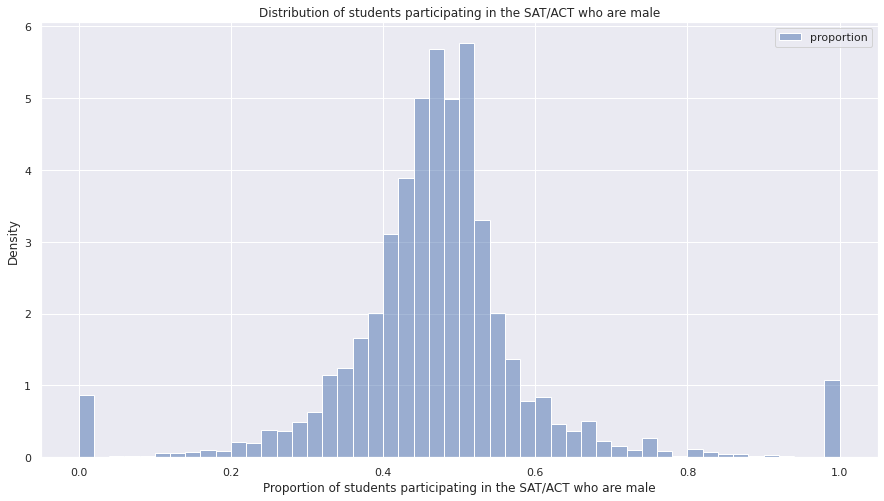

In [18]:
# Looking at proportions of SAT and ACT data by gender
sat_act_gender_proportions = pd.DataFrame()
sat_act_gender_proportions['proportion'] = clean_directory_sat_act_df['sex_race_disability_lep_1_99_99_99'] / clean_directory_sat_act_df['sex_race_disability_lep_99_99_99_99']
sns.histplot(sat_act_gender_proportions, binwidth = 0.02, stat = 'density')
plt.xlabel('Proportion of students participating in the SAT/ACT who are male')
plt.title('Distribution of students participating in the SAT/ACT who are male')
plt.show()

In [19]:
# Total SAT ACT test takers by state
sat_act_df_sum = clean_directory_sat_act_df.groupby('state_location')['sex_race_disability_lep_99_99_99_99'].sum().reset_index()
sat_act_df_sum.rename(columns={'sex_race_disability_lep_99_99_99_99':'total'},inplace=True)
sat_act_df_sum

state_location     total
0              AK   4230.00
1              AL  57340.00
2              AR  44254.00
3              AZ  55986.00
4              CA 336203.00
5              CO  62200.00
6              CT  46678.00
7              DC   6086.00
8              DE   9243.00
9              FL 262094.00
10             GA 102044.00
11             HI  12324.00
12             IA  30547.00
13             ID  23771.00
14             IL 163083.00
15             IN  59029.00
16             KS  26764.00
17             KY  71819.00
18             LA  53542.00
19             MA  67682.00
20             MD  70498.00
21             ME  12117.00
22             MI 101605.00
23             MN  67496.00
24             MO  67443.00
25             MS  43788.00
26             MT  10029.00
27             NC 100297.00
28             ND   6836.00
29             NE  28725.00
30             NH  13102.00
31             NJ 113570.00
32             NM  33818.00
33             NV  40076.00
34             NY 200541.00
35             OH 159033.00
36             OK  48804.00
37             OR  27102.00
38             PA 114153.00
39             PR      0.00
40             RI  11710.00
41             SC  52933.00
42             SD   7585.00
43             TN 107728.00
44             TX 312479.00
45             VA  77248.00
46             VT   4610.00
47             WA  59650.00
48             WI  64174.00
49             WV  19584.00
50             WY   7224.00

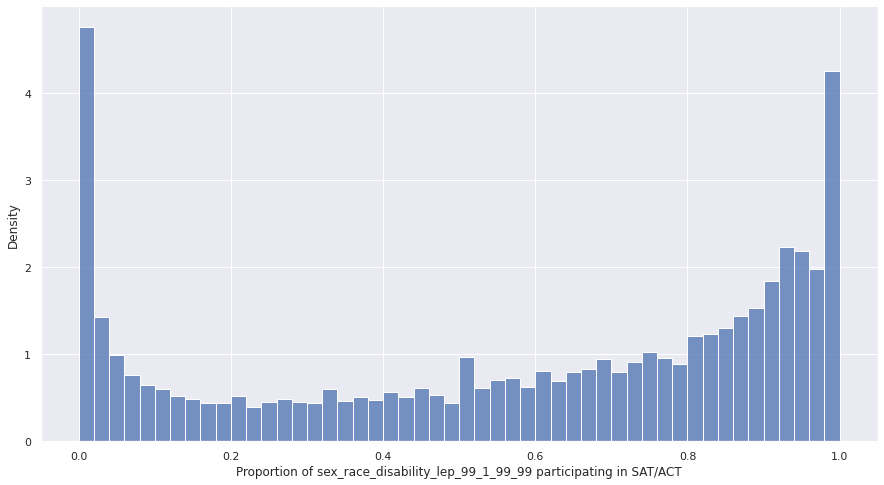

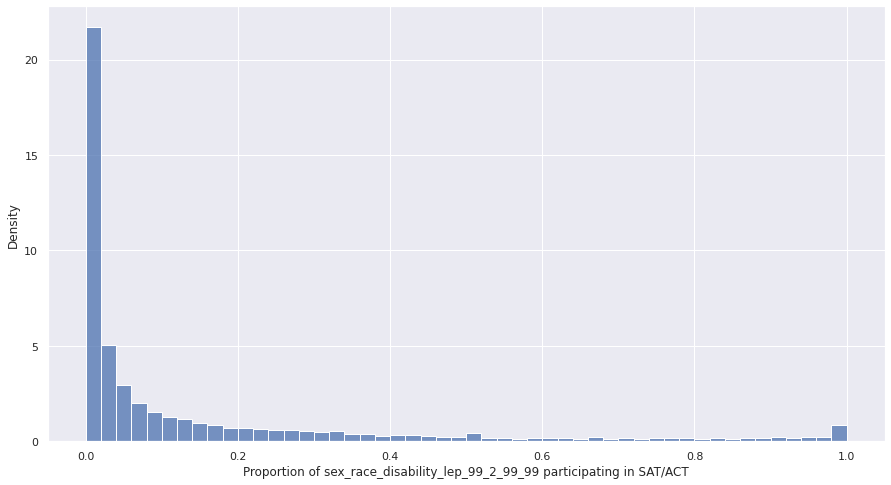

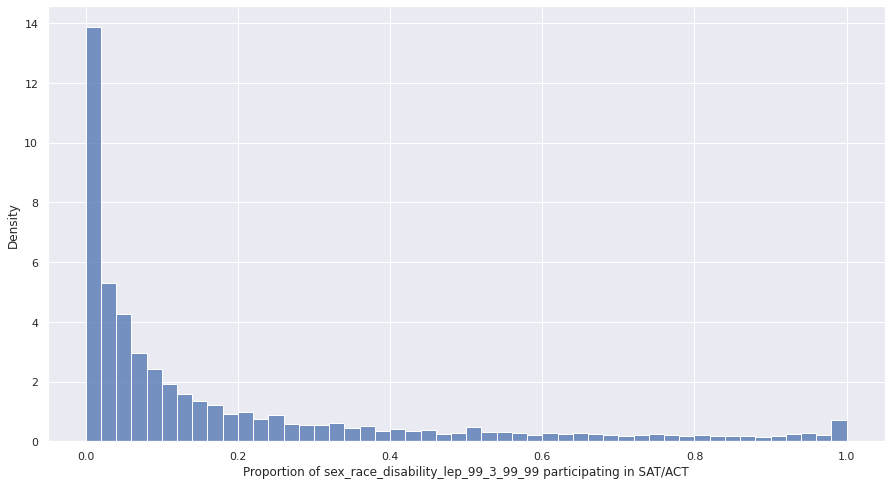

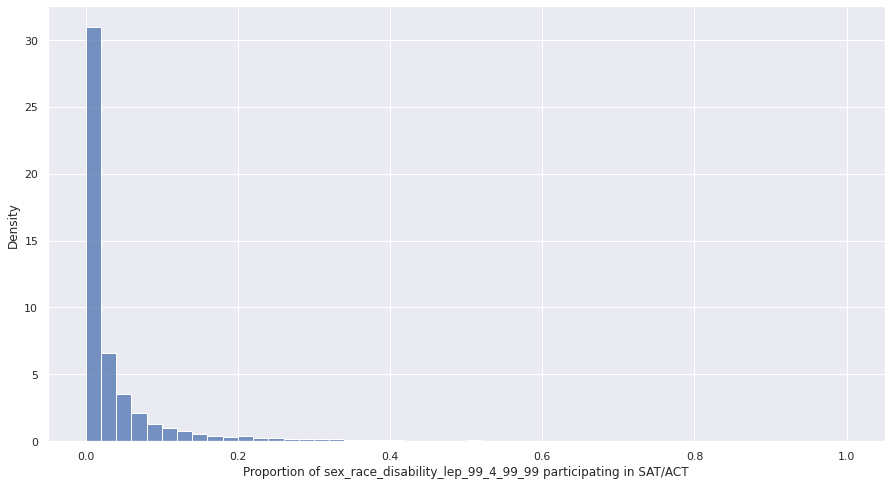

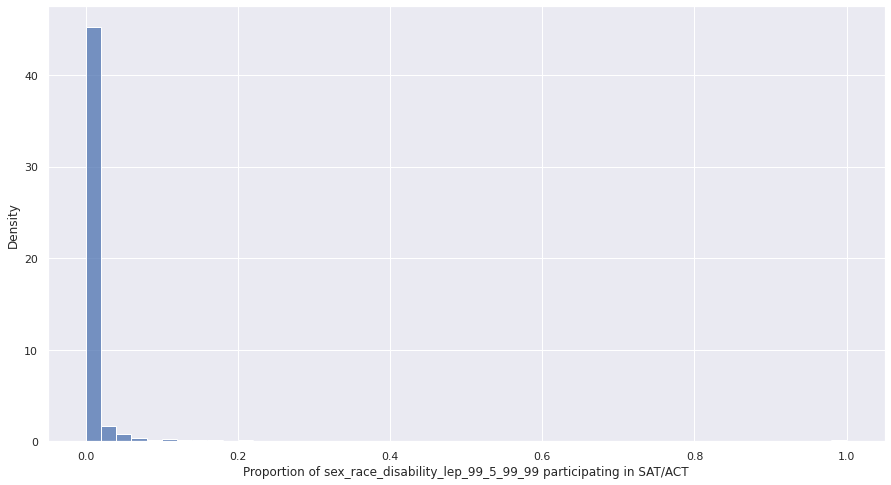

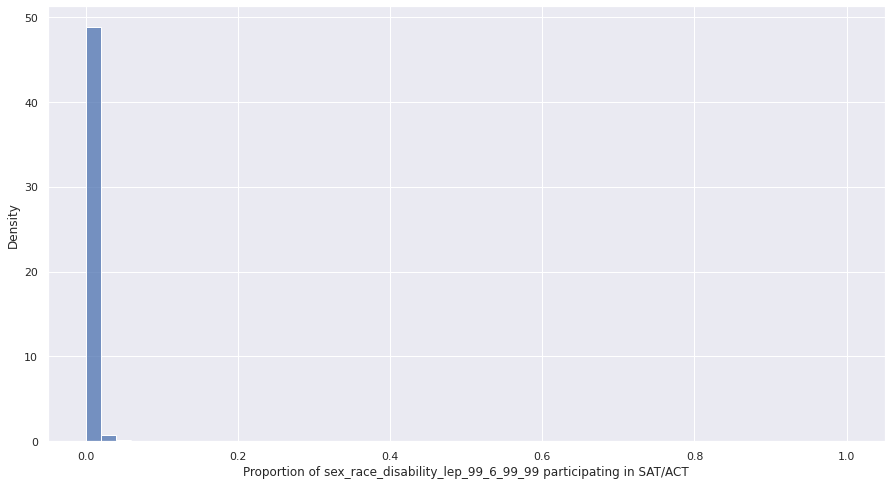

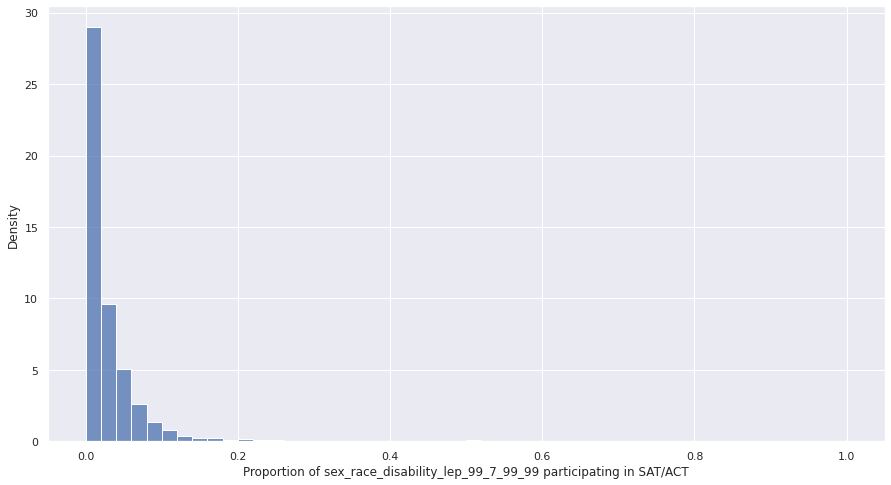

In [20]:
# proportions of SAT and ACT data by race

sat_act_race_proportions = pd.DataFrame()

race_cols = [
       'sex_race_disability_lep_99_1_99_99',
       'sex_race_disability_lep_99_2_99_99',
       'sex_race_disability_lep_99_3_99_99',
       'sex_race_disability_lep_99_4_99_99',
       'sex_race_disability_lep_99_5_99_99',
       'sex_race_disability_lep_99_6_99_99',
       'sex_race_disability_lep_99_7_99_99'
]

for c in race_cols:
    sat_act_race_proportions[c] = clean_directory_sat_act_df[c]/clean_directory_sat_act_df['sex_race_disability_lep_99_99_99_99']

for c in sat_act_race_proportions.columns:
  sns.histplot(sat_act_race_proportions[c], binwidth = 0.02, stat = 'density')
  plt.xlabel('Proportion of ' + str(c) + ' participating in SAT/ACT')
  plt.show()

### State Test Scores

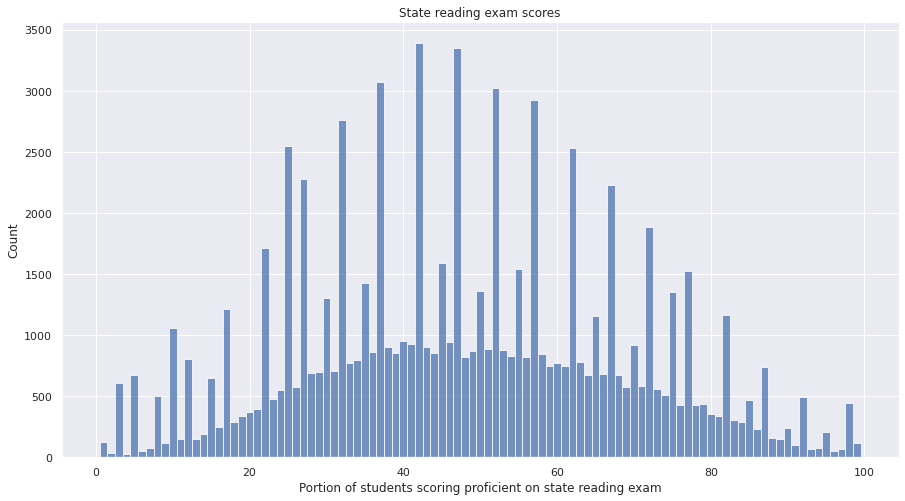

In [21]:
# Plot the percentage of students scoring proficient in the state reading exam
read_eda = read_df[['ncessch','fips','read_test_num_valid','grade_sex_race_disability_lep_disadv_99_99_99_99_99_99']]

# plot 
sns.histplot(read_eda.grade_sex_race_disability_lep_disadv_99_99_99_99_99_99, binwidth = 1)
plt.xlabel('Portion of students scoring proficient on state reading exam')
plt.title('State reading exam scores')
plt.show()

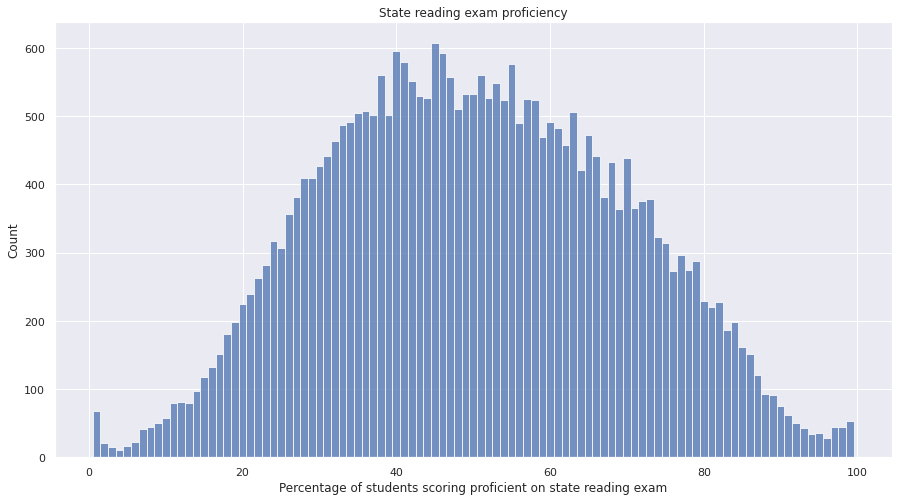

In [22]:
# Same plot, but only using data from schools with more than 300 people taking the exam
read_eda_big = read_eda[read_eda.read_test_num_valid > 300]

sns.histplot(read_eda_big.grade_sex_race_disability_lep_disadv_99_99_99_99_99_99, binwidth = 1)
plt.xlabel('Percentage of students scoring proficient on state reading exam')
plt.title('State reading exam proficiency')
plt.show()

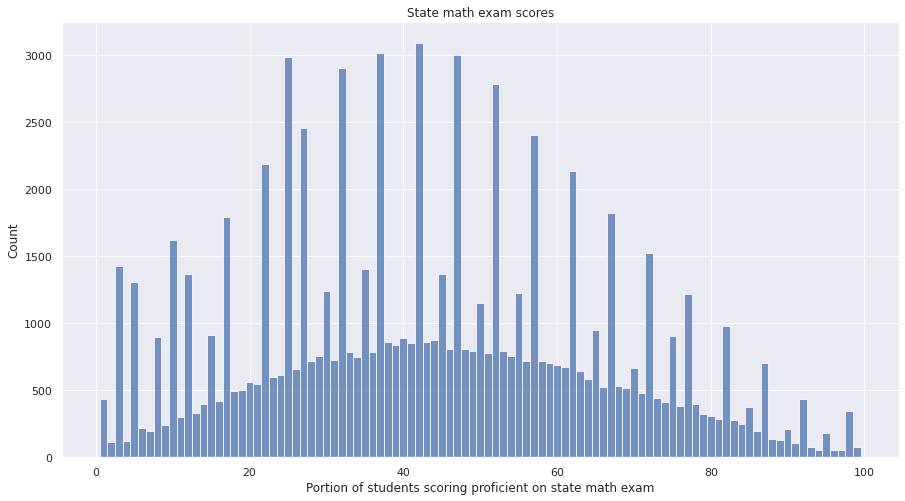

In [23]:
sns.histplot(math_df.grade_sex_race_disability_lep_disadv_99_99_99_99_99_99,binwidth = 1)
plt.xlabel('Portion of students scoring proficient on state math exam')
plt.title('State math exam scores')
plt.show()

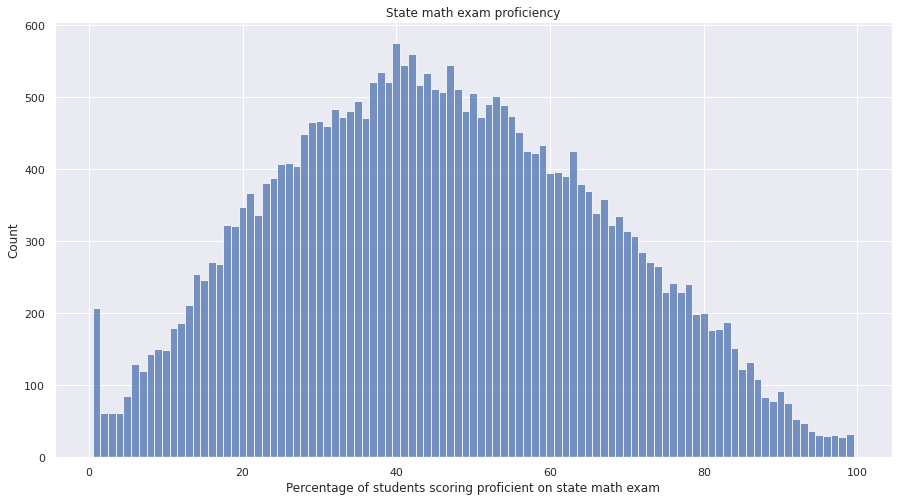

In [24]:
# Same plot as bove, but only using data from schools with more than 300 people taking the exam
math_eda = math_df[['ncessch','fips','math_test_num_valid','grade_sex_race_disability_lep_disadv_99_99_99_99_99_99']]
math_eda_big = math_eda[math_eda.math_test_num_valid > 300]

sns.histplot(math_eda_big.grade_sex_race_disability_lep_disadv_99_99_99_99_99_99, binwidth = 1)
plt.xlabel('Percentage of students scoring proficient on state math exam')
plt.title('State math exam proficiency')
plt.show()

### Correlation 

In [25]:
# Select only a small subset of numerical columns 
df_for_corr = clean_directory_sat_act_df[['free_or_reduced_price_lunch','lowest_grade_offered', 'teachers_fte', 'enrollment', 'sex_race_disability_lep_1_99_99_99',
                                          'sex_race_disability_lep_2_99_99_99', 'sex_race_disability_lep_99_1_99_99','sex_race_disability_lep_99_2_99_99',
                                          'sex_race_disability_lep_99_3_99_99', 'sex_race_disability_lep_99_4_99_99', 'sex_race_disability_lep_99_5_99_99',
                                          'sex_race_disability_lep_99_6_99_99', 'sex_race_disability_lep_99_7_99_99', 'sex_race_disability_lep_99_99_99_99',
                                          'pct_sat_act']].copy()

# Assume that if there were NAs in free/reduced lunch, free/reduced lunch was not offered
df_for_corr['free_or_reduced_price_lunch'] = (df_for_corr.free_or_reduced_price_lunch.fillna(0)).astype(int)

# Cast to correct type
df_for_corr['lowest_grade_offered'] = (df_for_corr.lowest_grade_offered).astype(int)
df_for_corr['teachers_fte'] = (df_for_corr.teachers_fte).astype(float)

# Create new columns that expresses numbers "scaled" to enrollment
df_for_corr['stud_teacher_ratio'] = df_for_corr['enrollment'] / df_for_corr['teachers_fte']
df_for_corr['pct_stud_free_lunch'] = df_for_corr['free_or_reduced_price_lunch'] / df_for_corr['enrollment']

# Only look at non-outlier data, i.e. schools with a student/teacher ratio of below 100
df_for_corr = df_for_corr[df_for_corr.stud_teacher_ratio <= 100]

# Get rid of rows that say more students got free lunch than the overall student body
df_for_corr = df_for_corr[df_for_corr.pct_stud_free_lunch <= 1]

# Create correlations
corr = df_for_corr.corr()

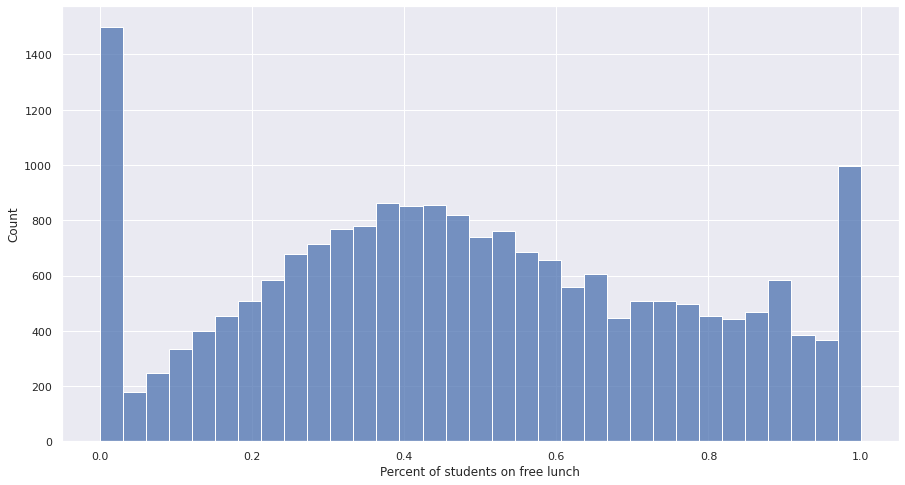

In [26]:
a = sns.histplot(df_for_corr['pct_stud_free_lunch'])
a.set(xlabel = 'Percent of students on free lunch');

15.632599092519184
14.995023693391975


[Text(0.5, 0, 'Student:Teacher ratio'),
 Text(0.5, 1.0, 'Distribution of Student:Teacher Ratios')]

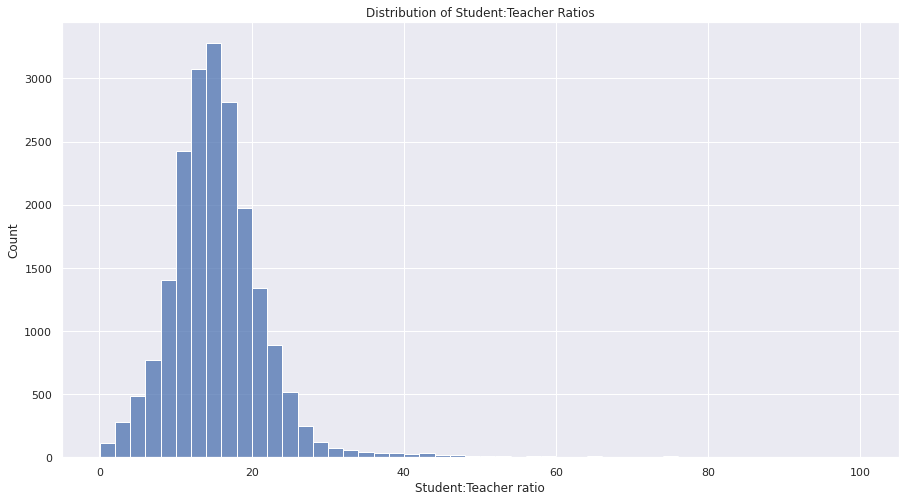

In [27]:
# Distribution of student:teacher ratios
print(df_for_corr['stud_teacher_ratio'].mean())
print(df_for_corr['stud_teacher_ratio'].median())
a = sns.histplot(df_for_corr['stud_teacher_ratio'],binwidth = 2)
a.set(xlabel = 'Student:Teacher ratio', title = 'Distribution of Student:Teacher Ratios')

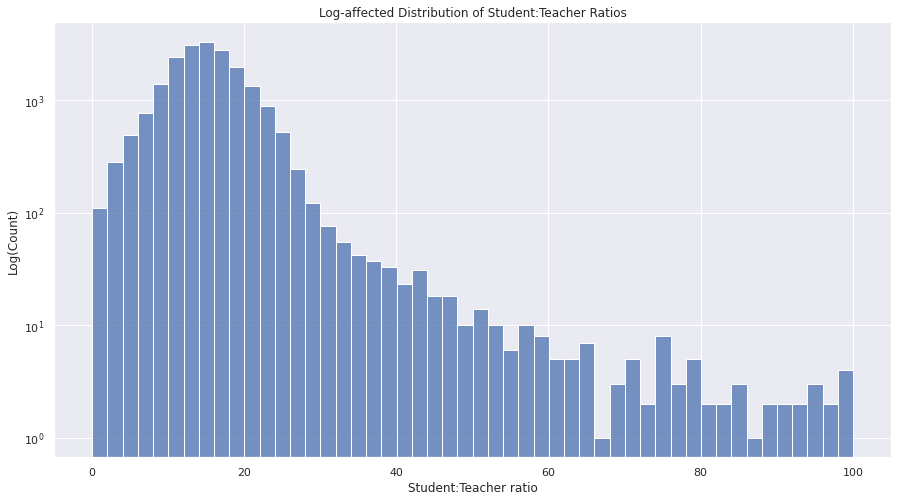

In [28]:
a = sns.histplot(df_for_corr['stud_teacher_ratio'],binwidth = 2,log_scale=(False,True))
a.set(xlabel='Student:Teacher ratio',ylabel= 'Log(Count)', title = 'Log-affected Distribution of Student:Teacher Ratios');

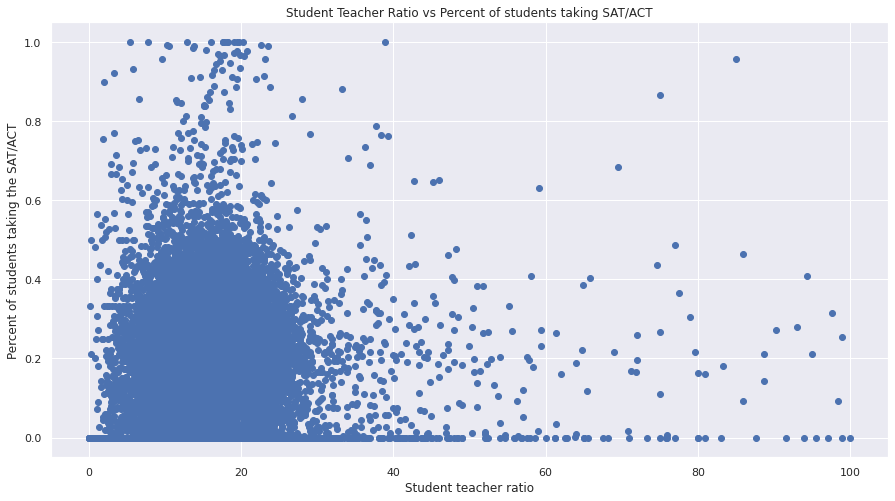

In [29]:
# Examine correlation between student:teacher ratio & pct students taking the ecam
plt.scatter(df_for_corr.stud_teacher_ratio, df_for_corr.pct_sat_act)
plt.xlabel('Student teacher ratio')
plt.ylabel('Percent of students taking the SAT/ACT')
plt.title('Student Teacher Ratio vs Percent of students taking SAT/ACT')
plt.show()

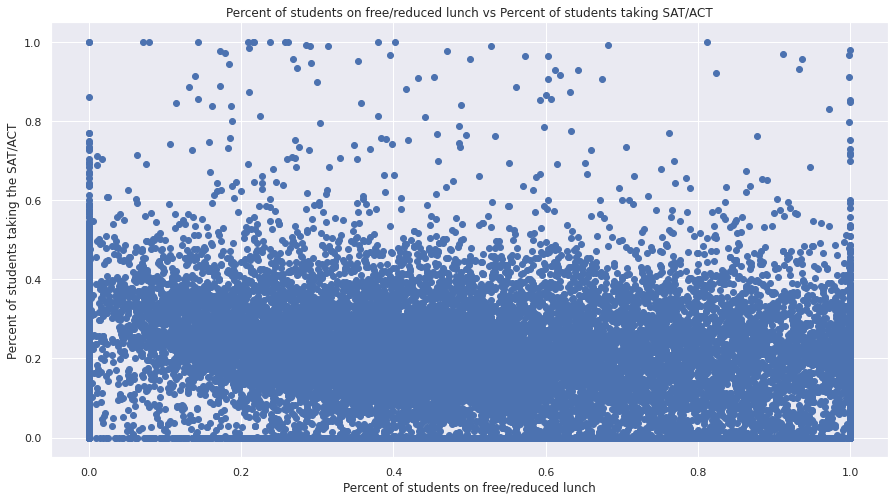

In [30]:
# Examine correlation between pct students on free lunch & pct students taking the ecam
plt.scatter(df_for_corr.pct_stud_free_lunch, df_for_corr.pct_sat_act)
plt.xlabel('Percent of students on free/reduced lunch')
plt.ylabel('Percent of students taking the SAT/ACT')
plt.title('Percent of students on free/reduced lunch vs Percent of students taking SAT/ACT')
plt.show()

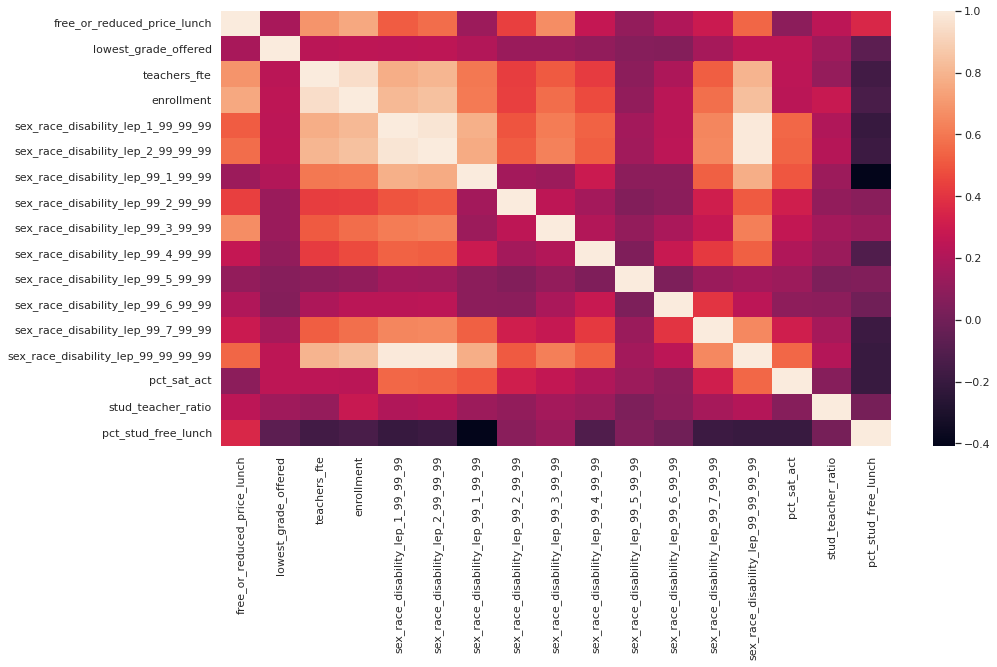

In [ ]:
# Visualize all correlations
sns.heatmap(corr)

### Choropleth

In [31]:
# Get the mean percentage of students taking the SAT & ACT by state
sat_act_df_pct = clean_directory_sat_act_df.groupby('state_location')['pct_sat_act'].mean().reset_index()
sat_act_df_pct

# Get the mean percentage of students with free/reduced lunch by state
clean_directory_sat_act_df['free_or_reduced_price_lunch'] = (clean_directory_sat_act_df.free_or_reduced_price_lunch.fillna(0)).astype(int)
clean_directory_sat_act_df['pct_stud_free_lunch'] = clean_directory_sat_act_df['free_or_reduced_price_lunch'] / clean_directory_sat_act_df['enrollment']

reduced_lunch_by_state = clean_directory_sat_act_df.groupby('state_location')['pct_stud_free_lunch'].mean().reset_index()

In [32]:
# Source: https://plotly.com/python/mapbox-county-choropleth/
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/loganpowell/census-geojson/master/GeoJSON/20m/2019/state.json') as response:
    states = json.load(response)

import plotly.express as px


fig = px.choropleth(sat_act_df_pct, locations='state_location', color='pct_sat_act',
                    color_continuous_scale="Viridis",
                    locationmode = 'USA-states',  
                    range_color=(0, sat_act_df_pct.pct_sat_act.max() + 0.01),
                    scope = 'usa',
                    labels={'pct_sat_act':'Percentage of students taking the SAT/ACT', }
                    )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [33]:
fig = px.choropleth(reduced_lunch_by_state, locations='state_location', color='pct_stud_free_lunch',
                    color_continuous_scale="Viridis",
                    locationmode = 'USA-states',  
                    range_color=(0, reduced_lunch_by_state.pct_stud_free_lunch.max() + 0.01),
                    scope = 'usa',
                    labels={'pct_stud_free_lunch':'Percentage of students on free or reduced lunch', }
                    )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

## PCA

In [34]:
# Creating helpful columms
alldata_df['free_or_reduced_price_lunch'] = (alldata_df.free_or_reduced_price_lunch.fillna(0)).astype(int)
alldata_df['lowest_grade_offered'] = (alldata_df.lowest_grade_offered).astype(int)
alldata_df['teachers_fte'] = (alldata_df.teachers_fte).astype(float)
alldata_df['stud_teacher_ratio'] = alldata_df['enrollment'] / alldata_df['teachers_fte']
alldata_df['pct_stud_free_lunch'] = alldata_df['free_or_reduced_price_lunch'] / alldata_df['enrollment']

In [35]:
# Before we run the PCA...
# We begin by dropping duplicate columns and non-numerical columns
pca_alldata_df = alldata_df.drop(columns=[
      'ncessch', 'school_name','school_name_x', 'school_name_y', 
      'fips_y', 'fips_math', 'fips_read',
      'leaid', 'lea_name', 'state_leaid', 'seasch',
       'street_mailing', 'city_mailing', 'state_mailing', 'zip_mailing',
       'street_location', 'city_location', 'state_location', 
       'title_i_status', 'title_i_eligible',
       'free_or_reduced_price_lunch', 
       'teachers_fte', 
       'congress_district_id', 'state_leg_district_lower',
       'state_leg_district_upper', 'county_code', 'crdc_id'])

In [36]:
# Cast all columns to floats
for c in pca_alldata_df.columns:
  pca_alldata_df[c] = pca_alldata_df[c].astype(float)

In [37]:
# Remove all infinities, which happened when we divided by 0
pca_alldata_df.replace([np.inf, -np.inf], np.nan, inplace=True)
pca_alldata_df.isna().sum().sum()
pca_alldata_df.dropna(inplace=True)

In [38]:
# Standard scaling

from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(pca_alldata_df)
X

array([[-0.62288911, -1.6415866 , -0.59925471, ..., -0.44482137,
         0.05856747,  0.63785114],
       [-0.62288911, -1.6415866 , -0.59890816, ...,  1.9189583 ,
         0.01690197,  0.21313531],
       [-0.62288911, -1.6415866 , -0.59701643, ..., -0.44482137,
         0.07177771,  0.66787951],
       ...,
       [-1.82468689,  2.63612027, -3.31065047, ..., -0.44482137,
        -0.06216793,  1.29317876],
       [-1.82671492,  2.63612027, -3.30044654, ..., -0.44482137,
        -0.02345887,  1.30306381],
       [-1.83479268,  2.63612027, -3.29875469, ..., -0.44482137,
         0.01204869,  1.31104819]])

In [39]:
pca_alldata_df.shape
# Note that we started off with 230 columns

(82166, 230)

In [40]:
from sklearn.decomposition import PCA

pca = PCA(n_components=230)
X2 = pca.fit_transform(X)

Text(0, 0.5, 'Explained Variance Ratio')

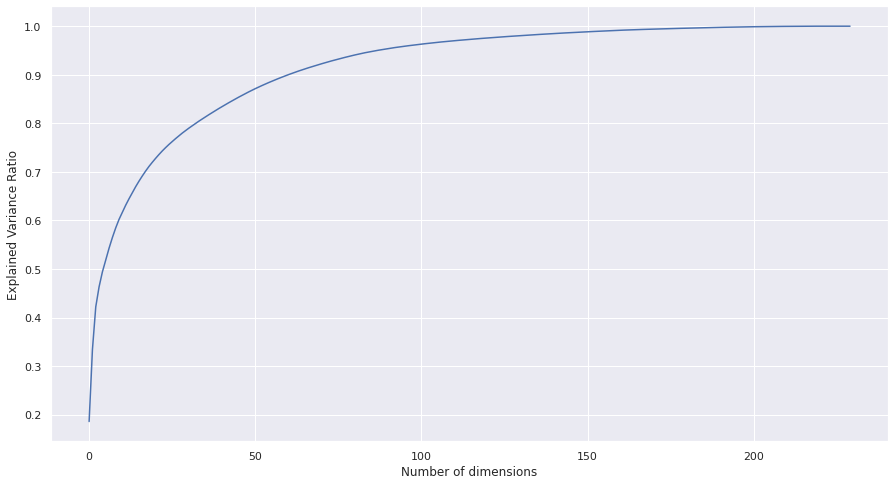

In [41]:
np.set_printoptions(suppress=True)
pc_vs_variance = np.cumsum(pca.explained_variance_ratio_)

pc_vs_variance
plt.plot(pc_vs_variance);
plt.xlabel('Number of dimensions')
plt.ylabel('Explained Variance Ratio')

In [42]:
(np.cumsum(pca.explained_variance_ratio_)<0.95).sum()
# At 88 components, we get a 95% explained variance ratio

87

## tSNE

In [43]:
from sklearn.manifold import TSNE

# X_embedded = TSNE(n_components=2).fit_transform(X)
# Running this will take ~23 minutes

# Save to csv so we don't have to run tSNE multiple times
# np.savetxt('X_embedded.csv', X_embedded , delimiter=",")
# Note: this file is already uploaded to our google drive

# For future runs:
X_embedded = np.genfromtxt('tsne_output.csv', delimiter=',')
X_embedded

array([[ 11.89235783, -39.67980957],
       [ 31.36249924,  14.65685081],
       [ 22.76497459,  21.72254753],
       ...,
       [  0.00308294, -52.48051834],
       [ -0.18529691, -52.94190598],
       [-31.78091621, -41.77600479]])

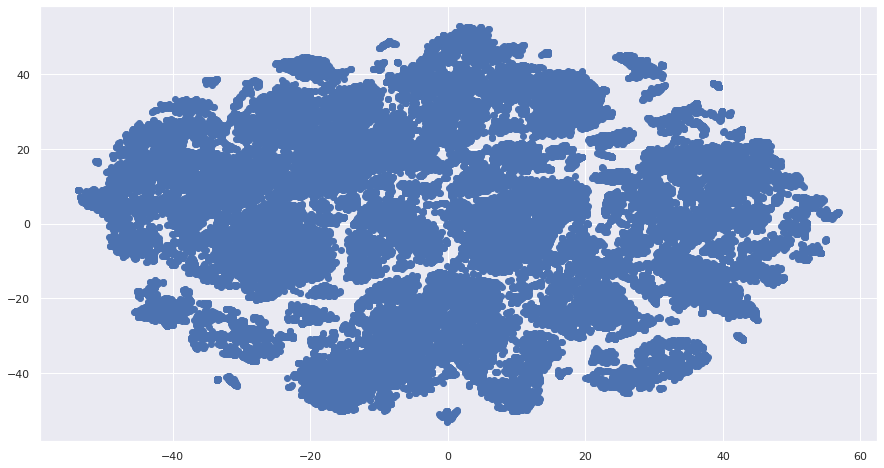

In [44]:
# Plot the raw output of the tSNE algorithm
plt.scatter(X_embedded[:,0],X_embedded[:,1])

### Attempting to understand what the neighborhoods in the graph above represent:

In [45]:
# Encoding original data wiht the x and y values of the tSNE reduced graph
pca_alldata_df['tsne_x'] = X_embedded[:,0]
pca_alldata_df['tsne_y'] = X_embedded[:,1]

[Text(0, 0.5, 'tSNE Dimension 2'),
 Text(0.5, 0, 'tSNE Dimension 1'),
 Text(0.5, 1.0, 'tSNE Classified by School Level')]

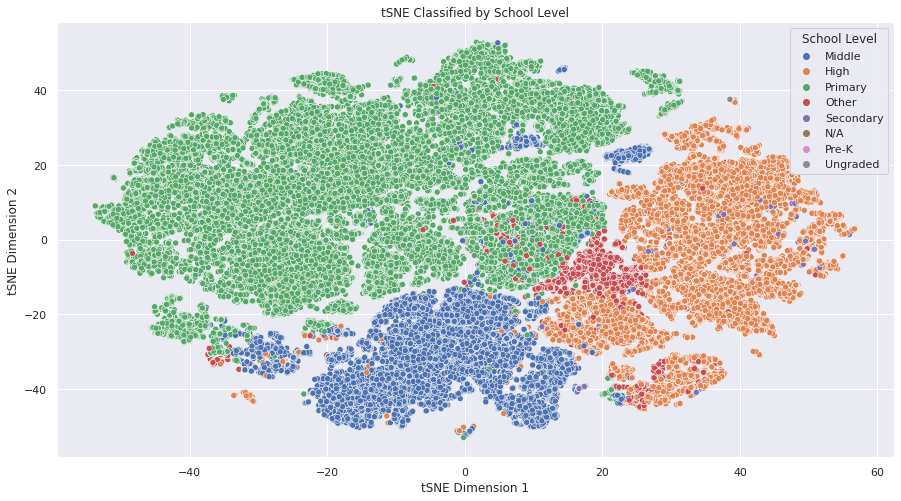

In [47]:
pca_alldata_df['School Level'] = pca_alldata_df['school_level'].map({-2: 'N/A', 
                                                                     0: 'Pre-K',
                                                                     1:'Primary',
                                                                     2:'Middle',
                                                                     3:'High',
                                                                     4:'Other',
                                                                     5:'Ungraded',
                                                                     7:'Secondary'})
a = sns.scatterplot(data=pca_alldata_df,x='tsne_x',y='tsne_y',hue = 'School Level',palette = 'deep')
a.set(xlabel = 'tSNE Dimension 1',ylabel = 'tSNE Dimension 2',title = 'tSNE Classified by School Level')

[Text(0, 0.5, 'tSNE Dimension 2'),
 Text(0.5, 0, 'tSNE Dimension 1'),
 Text(0.5, 1.0, 'tSNE Classified by School Status')]

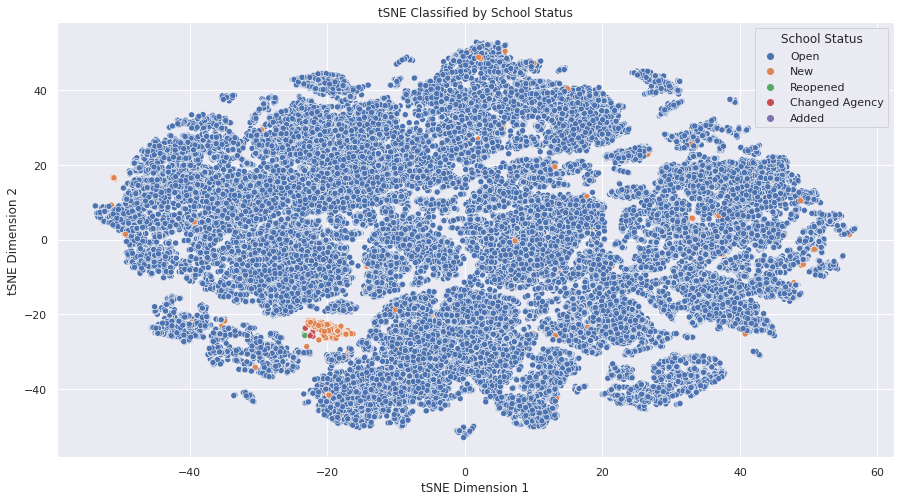

In [50]:
pca_alldata_df['School Status'] = pca_alldata_df['school_status'].map({1: 'Open', 3: 'New', 4:'Added',5:'Changed Agency',8:'Reopened'})

a = sns.scatterplot(data=pca_alldata_df,x='tsne_x',y='tsne_y',hue = 'School Status',palette = 'deep')
a.set(xlabel = 'tSNE Dimension 1',ylabel = 'tSNE Dimension 2', title = 'tSNE Classified by School Status')

[Text(0, 0.5, 'tSNE Dimension 2'),
 Text(0.5, 0, 'tSNE Dimension 1'),
 Text(0.5, 1.0, 'tSNE Classified by School Type')]

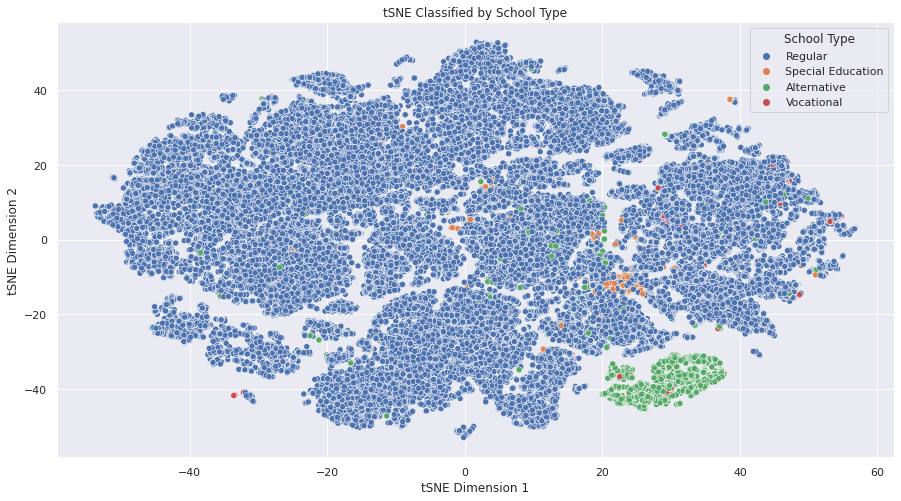

In [51]:
pca_alldata_df['School Type'] = pca_alldata_df['school_type'].map({1: 'Regular', 2: 'Special Education', 3: 'Vocational',4:'Alternative'})

a = sns.scatterplot(data=pca_alldata_df,x='tsne_x',y='tsne_y',hue = 'School Type',palette = 'deep')
a.set(xlabel = 'tSNE Dimension 1',ylabel = 'tSNE Dimension 2', title = 'tSNE Classified by School Type')

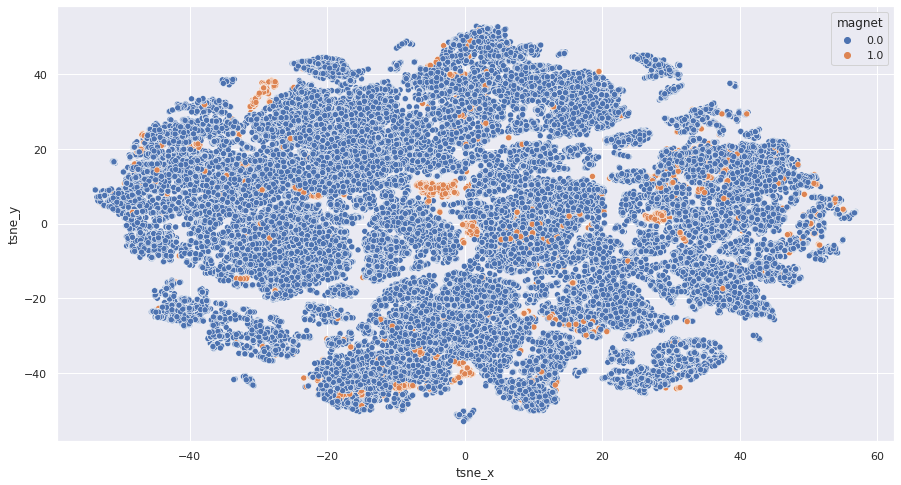

In [52]:
sns.scatterplot(data=pca_alldata_df,x='tsne_x',y='tsne_y',hue = 'magnet',palette = 'deep')

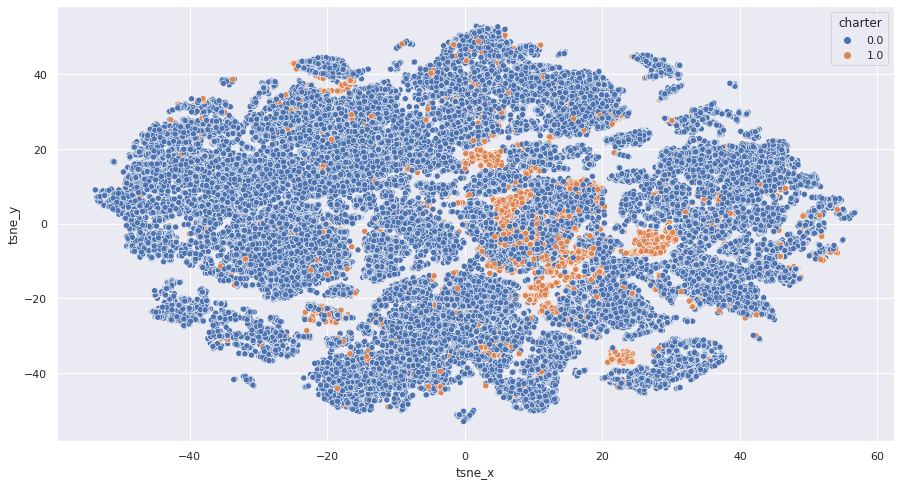

In [53]:
sns.scatterplot(data=pca_alldata_df,x='tsne_x',y='tsne_y',hue = 'charter',palette = 'deep')

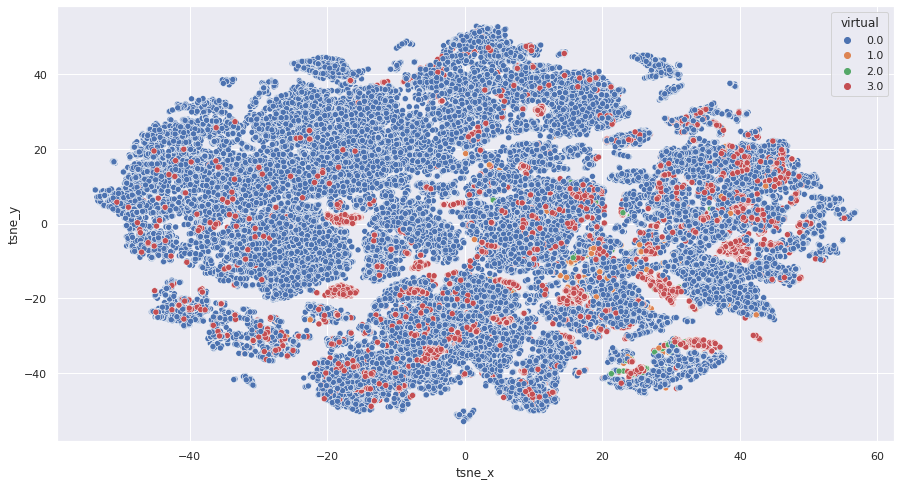

In [54]:
sns.scatterplot(data=pca_alldata_df,x='tsne_x',y='tsne_y',hue = 'virtual',palette = 'deep')

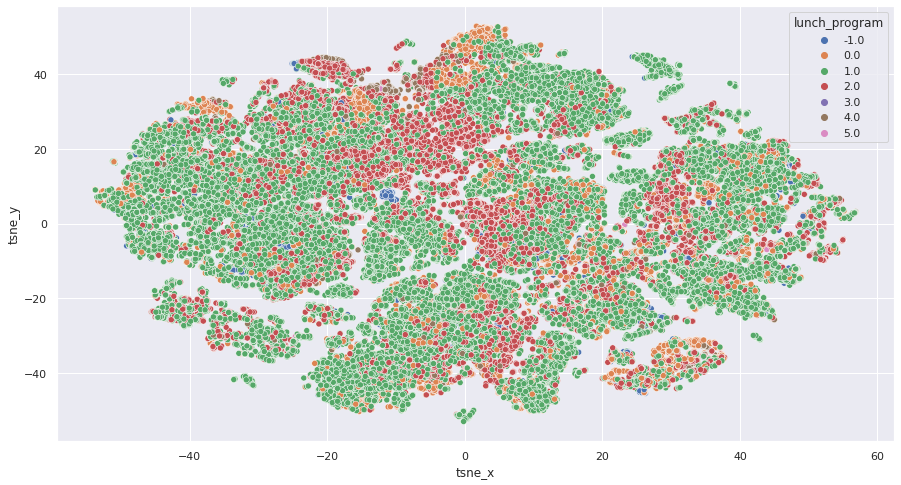

In [55]:
sns.scatterplot(data=pca_alldata_df,x='tsne_x',y='tsne_y',hue = 'lunch_program',palette = 'deep')

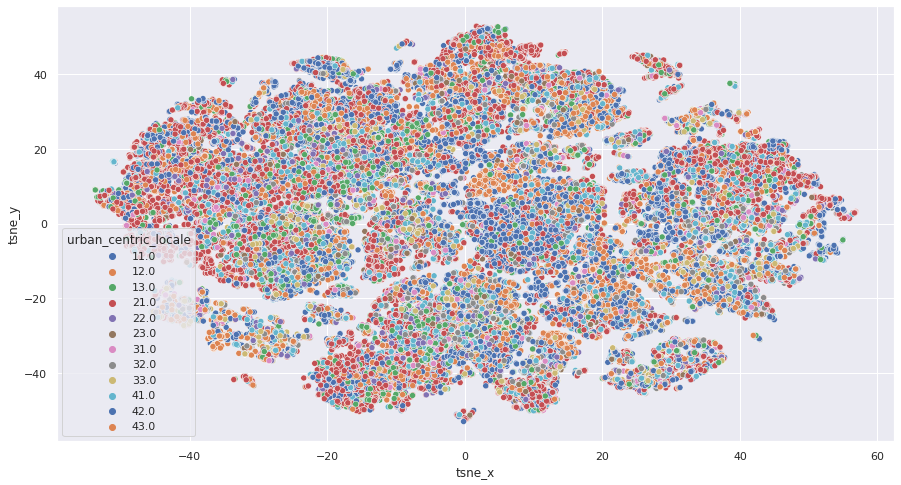

In [56]:
sns.scatterplot(data=pca_alldata_df,x='tsne_x',y='tsne_y',hue = 'urban_centric_locale',palette = 'deep')

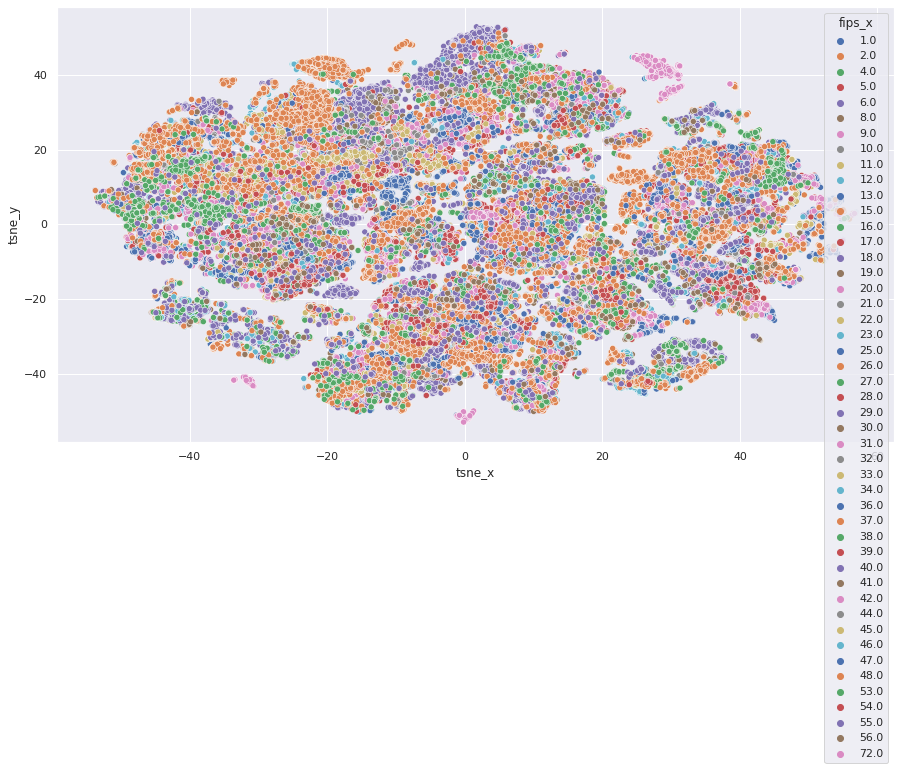

In [57]:
sns.scatterplot(data=pca_alldata_df,x='tsne_x',y='tsne_y',hue = 'fips_x',palette = 'deep')

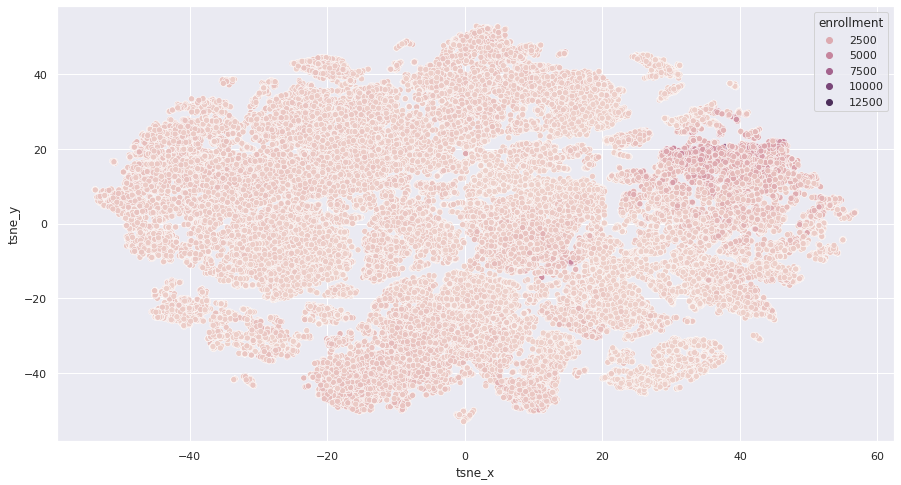

In [58]:
sns.scatterplot(data=pca_alldata_df,x='tsne_x',y='tsne_y',hue = 'enrollment')

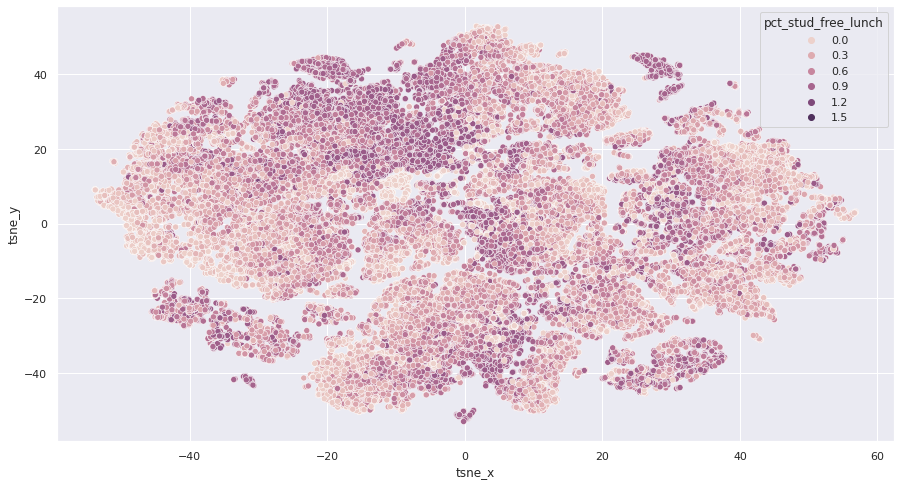

In [60]:
sns.scatterplot(data=pca_alldata_df,x='tsne_x',y='tsne_y',hue = 'pct_stud_free_lunch')

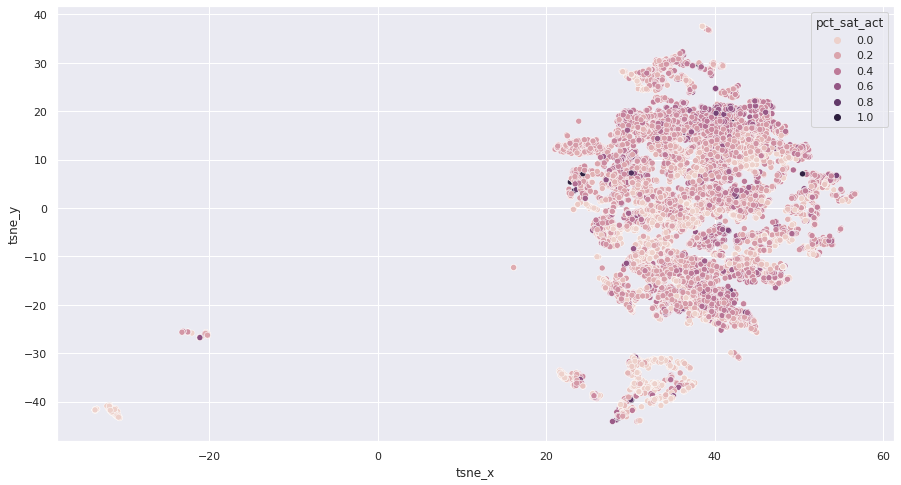

In [62]:
sns.scatterplot(data=pca_alldata_df[pca_alldata_df.lowest_grade_offered >= 9],x='tsne_x',y='tsne_y',hue = 'pct_sat_act')

## Linear Regression

### SAT & ACT Predictions

In [69]:
# Creating helpful lists of columns
sat_dummies = [c for c in sat_act_df.columns if 'sex_race_disability_lep_' in c and 'grade_' not in c]

In [80]:
# Dropping the below columns because we will only be using high school data
sat_predict = pca_alldata_df.drop(columns = [
'school_level',
'lowest_grade_offered',
'highest_grade_offered',
'ungrade_cedp',
'elem_cedp',
'middle_cedp',

# We also drop the columns we created for the tSNE visualization
'School Level',
'Lowest Grade Offered',
'School Status',
'School Type',
'tsne_x',
'tsne_y'
])

# https://educationdata.urban.org/documentation/schools.html#crdc-sat-and-act-participation-by-race-and-sex
# As explained in the link above, all lunch programs with code more than 1 
# just means the school operates lunch programs under different legal provisions
sat_predict[sat_predict.lunch_program > 1] = 1

# Get dummies of categorical variables
sat_predict = pd.get_dummies(sat_predict, columns = [
 'fips_x',
 'urban_centric_locale',
 'school_type',
 'school_status'
 ])

In [81]:
# Only select high school data 
highschool_df = sat_predict[sat_predict.high_cedp == 1]
sat_dummies.extend(['pct_sat_act'])

# Scale the data
X_sat = StandardScaler().fit_transform(highschool_df.drop(columns = sat_dummies))
y_sat = highschool_df['pct_sat_act']

In [82]:
# Note that we start off with 258 columns
X_sat.shape

(36670, 258)

Text(0, 0.5, 'Explained Variance Ratio')

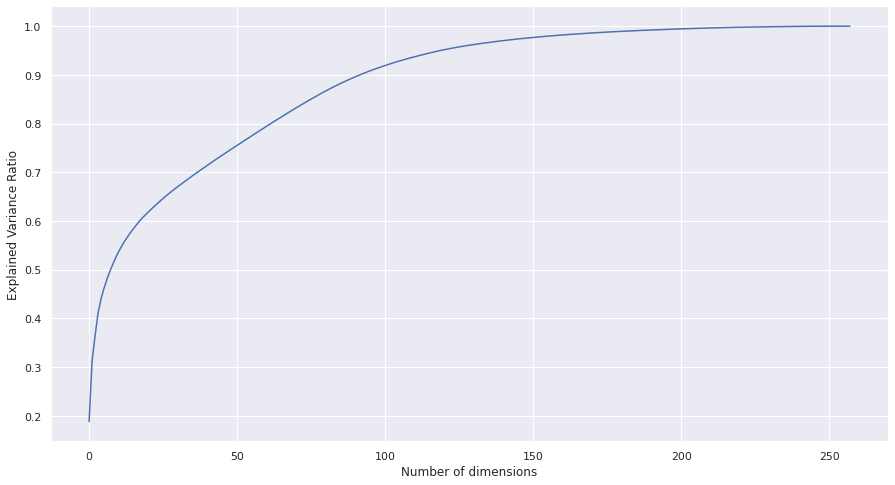

In [83]:
# Conduct PCA to reduce the number of dimensions
pca = PCA(n_components=258)
pca.fit_transform(X_sat)
np.set_printoptions(suppress=True)
pc_vs_variance = np.cumsum(pca.explained_variance_ratio_)

pc_vs_variance
plt.plot(pc_vs_variance);
plt.xlabel('Number of dimensions')
plt.ylabel('Explained Variance Ratio')

In [84]:
(np.cumsum(pca.explained_variance_ratio_)<0.95).sum()
# At 120 components, we get a 95% explained variance ratio

119

In [85]:
pca = PCA(n_components=120)
X_sat_pca = pca.fit_transform(X_sat)

In [86]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_sat_pca, y_sat, test_size=0.4)

Training Score: 0.5344668792670215
MAE: 0.20193889102872042
MSE: 0.11032954440601778
RMSE: 0.3321589143858972


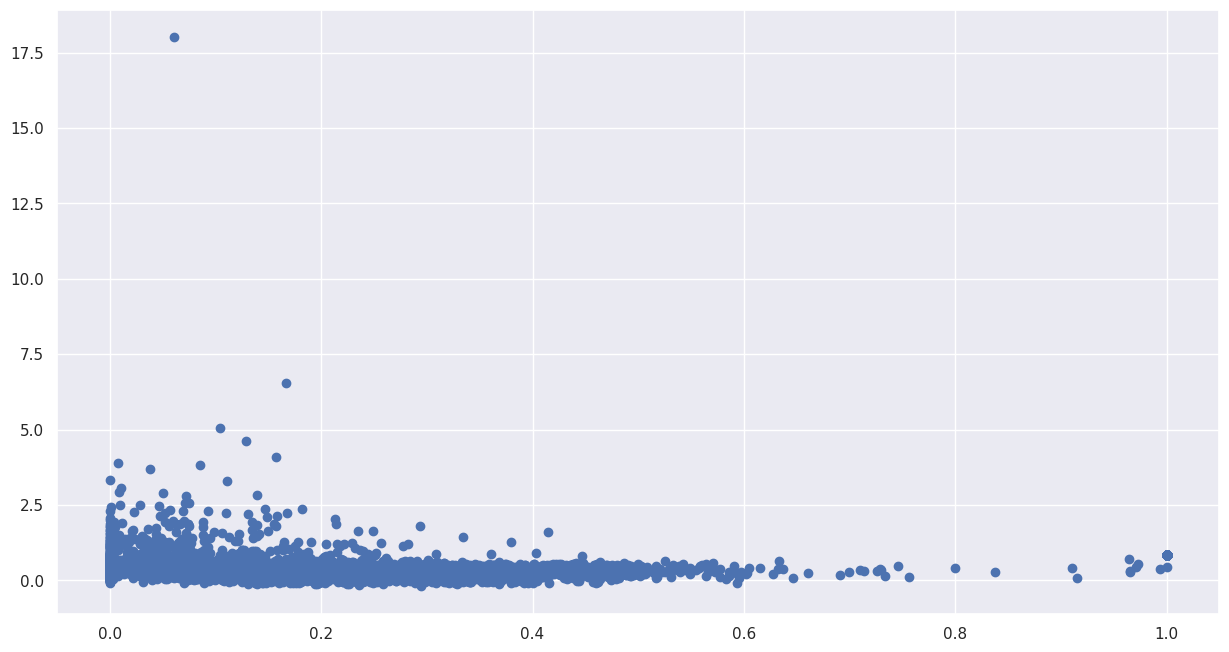

In [96]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

clf = LinearRegression(positive=True)
clf.fit(X_train, y_train)


predictions = clf.predict(X_test)
print("Training Score:", clf.score(X_train, y_train))
plt.figure(dpi=100)
plt.scatter(y_test, predictions)

# Different error measures
print("MAE:", mean_absolute_error(y_test, predictions))
print('MSE:', mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(mean_squared_error(y_test, predictions)))



In [88]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [98]:
# Note that the cross-validation r2 is also pretty low 
cross_val = KFold(n_splits=5,shuffle=True,random_state = 0)
r2 = np.mean(cross_val_score(clf, X_train, y_train, cv = cross_val))

print(r2)

0.48703640103300483


In [92]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Conduct a Lasso & gridsearchCV to find appropriate hyperparameters

# Keep grid small to run quickly - alpha between 0 and 1
alphas = np.logspace(start=-5,stop=-0.5,num=20,base=10.0)

def lasso_gs(alphas):
    tuned_params = {'alpha': alphas}
    lr = Lasso()
    lr_gs = GridSearchCV(lr,
                         param_grid=tuned_params, 
                         cv=5,
                         refit=False,
                         n_jobs=2,
                         verbose=10,
                        ).fit(X_train,y_train)

    return lr_gs
    
lr_gs = lasso_gs(alphas)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [93]:
print(f"Best parameter: {lr_gs.best_params_['alpha']:.4f} and score {lr_gs.best_score_:.2%}")

Best parameter: 0.0002 and score 95.74%


In [99]:
from sklearn.linear_model import Ridge

# Conduct a Lasso & gridsearchCV to find appropriate hyperparameters

def ridge_gs(alphas):
    tuned_params = {'alpha': alphas}
    lr = Ridge()
    lr_gs = GridSearchCV(lr,
                         param_grid=tuned_params, 
                         cv=5,
                         refit=False,
                         n_jobs=2,
                         verbose=10,
                        ).fit(X_train,y_train)

    return lr_gs
    
lr_gs = ridge_gs(alphas)
print(f"Best parameter: {lr_gs.best_params_['alpha']:.4f} and score {lr_gs.best_score_:.2%}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameter: 0.3162 and score 95.73%


In [100]:
from sklearn.linear_model import ElasticNet

# Conduct a ElasticNet & gridsearchCV to find appropriate hyperparameters

ratios = np.linspace(start=1.0,stop=1.0,num=10)
new_alphas = np.logspace(start=-5,stop=-0.5,num=10,base=10.0)

def en_gs(alphas,ratios):
    tuned_params = {'alpha': alphas,
                    'l1_ratio' : ratios}
    m = ElasticNet()
    m_gs = GridSearchCV(m,
                         param_grid=tuned_params, 
                         cv=3,
                         refit=False,
                         n_jobs=2,
                         verbose=10,
                        ).fit(X_train,y_train)

    return m_gs
    
m_gs = en_gs(new_alphas,ratios)

print(f"Best parameter: {m_gs.best_params_['alpha']:.4f} and {m_gs.best_params_['l1_ratio']:.4f} and score {m_gs.best_score_:.2%}")

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best parameter: 0.0003 and 1.0000 and score 95.72%


Training Score: 0.9587486400313515
Test data Score: 0.9581185932036776


Text(0.5, 1.0, 'Actual vs Predicted Percentage of Students Taking the SAT/ACT')

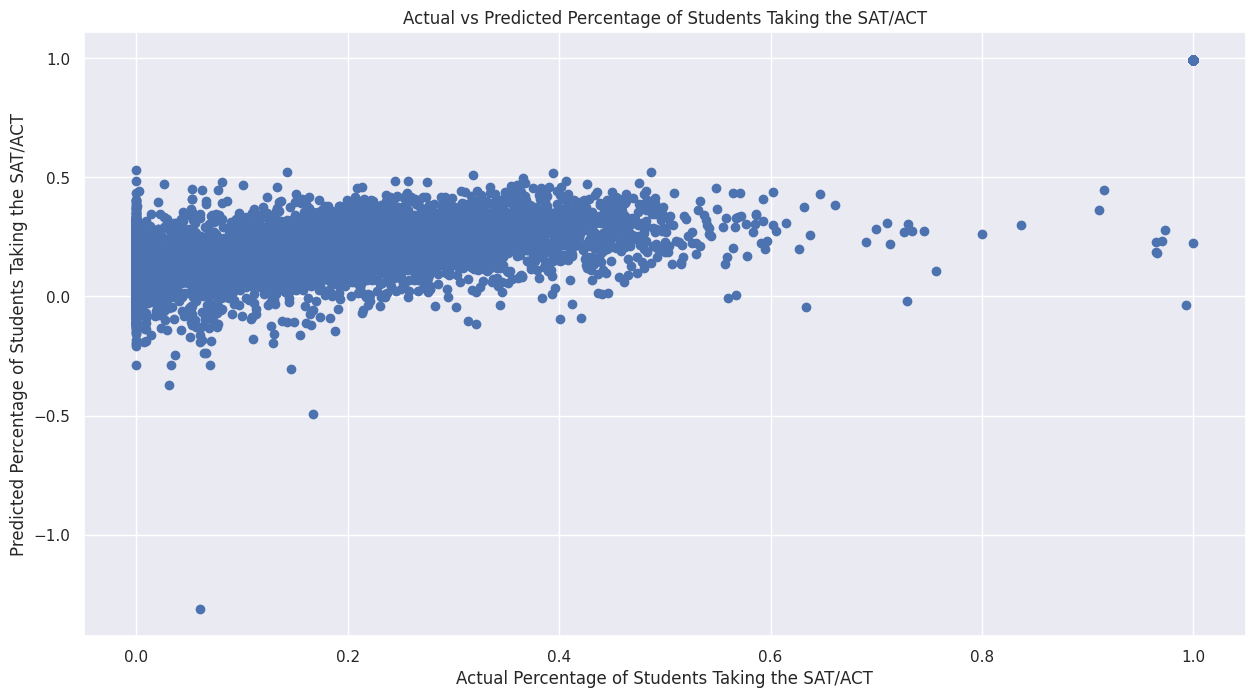

In [103]:
# Note that with the ElasticNet model from above
# The model was "best" as measured by r2 when the L1 ratio was 1.0, 
# i.e. when the model is a Lasso model , 
# Thus our final model is a lasso model with alphia 0.0003

final = Lasso(alpha = 0.0003)
final.fit(X_train, y_train)

print("Training Score:", final.score(X_train, y_train))
print("Test data Score:", final.score(X_test, y_test))

plt.figure(dpi=100)
predictions = final.predict(X_test)
plt.scatter(y_test, predictions)
plt.xlabel('Actual Percentage of Students Taking the SAT/ACT')
plt.ylabel('Predicted Percentage of Students Taking the SAT/ACT')
plt.title('Actual vs Predicted Percentage of Students Taking the SAT/ACT')